In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet


NumPy, Pandas, TensorFlow ve Keras gibi kütüphaneler kullanıldı ve görüntü verileri ile çalışmak için altyapı hazırlandı.

Index(['FilePaths', 'Labels'], dtype='object')


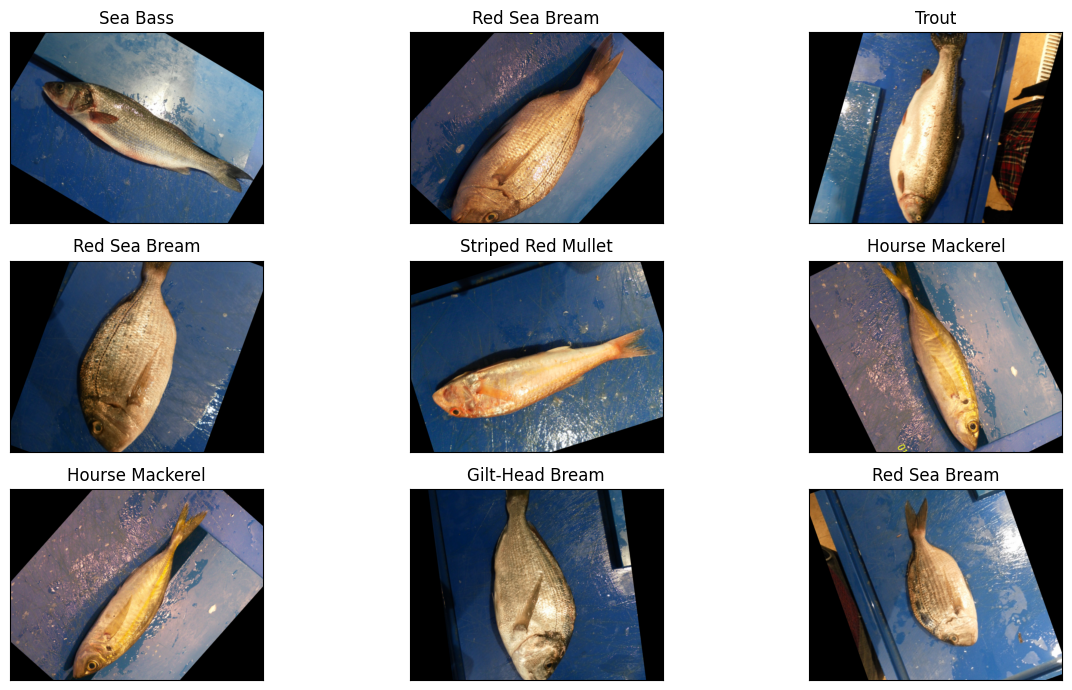

In [2]:
import matplotlib.pyplot as plt

# DataFrame'deki sütun adlarını kontrol et
print(img_df.columns)  # Sütun adlarını kontrol et

# Görüntüleri göster
f, a = plt.subplots(nrows=3, ncols=3, figsize=(13, 7),
                     subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df['FilePaths'].iloc[i]))  # Sütun adını güncelledik
    ax.set_title(img_df['Labels'].iloc[i])  # Sütun adını güncelledik

plt.tight_layout()
plt.show()

⁠ ⁠Bu kod, görüntü verisini incelemek ve etiketlerle birlikte görselleştirmek için kullanıldı.

In [3]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


Pandas DataFrame'inin satır ve sütun sayısını göstermek için kullanıldı.


In [4]:
img_df['Labels'].value_counts(ascending=True)

Labels
Sea Bass              1000
Red Sea Bream         1000
Trout                 1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Gilt-Head Bream       1000
Red Mullet            1000
Shrimp                1000
Black Sea Sprat       1000
Name: count, dtype: int64

DataFrame'indeki "Labels" sütunundaki etiketlerin her birinin kaç kez tekrarlandığını saymak için kullanıldı.

In [5]:
from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

# Eğitim ve test setlerini ayır
x_train, x_temp = train_test_split(img_df, test_size=1 - train_ratio)

# Kalan veriyi doğrulama ve test setleri olarak ayır
x_val, x_test = train_test_split(x_temp, test_size=test_ratio / (test_ratio + validation_ratio))

# Şekilleri kontrol et
print(f'Shape of Training Data: {x_train.shape}')  # Eğitim verisinin boyutu
print(f'Shape of Validation Data: {x_val.shape}')  # Doğrulama verisinin boyutu
print(f'Shape of Testing Data: {x_test.shape}')     # Test verisinin boyutu

# x_test'in bir kopyasını oluştur
x_testt = x_test.copy()

Shape of Training Data: (6750, 2)
Shape of Validation Data: (900, 2)
Shape of Testing Data: (1350, 2)


⁠Veriyi düzenli bir şekilde ayırmak amacıyla kullanıldı. Ayrıca, test verisinin korunması, model değerlendirmesinde tutarlılık sağlaması amaçlandı.

In [6]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


Bu Python kodu, görüntü verilerini hazırlamak ve eğitim, test, doğrulama setleri için akış (flow) olarak almak için kullanıldı.

In [7]:
from tensorflow.keras.layers import Input

fc_model = tf.keras.models.Sequential([
  Input(shape=(224, 224, 3)),  # Doğru boyut: 224x224 piksel, 3 renk kanalı
  tf.keras.layers.Rescaling(1./255),  # Normalizasyon katmanı
  tf.keras.layers.Flatten(),  # Düzleştirme katmanı
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9, activation="softmax")  # 9 sınıf için softmax
])

Bu Python kodu, Keras kullanarak bir yapay sinir ağı (YSA) modeli oluşturdu.Modelin amacı, 224x224 piksel boyutunda ve 3 renk kanalı (RGB) olan görüntüleri alarak bunları 9 farklı sınıfa sınıflandırmaktır.

In [9]:
# Modeli derle
from keras.callbacks import EarlyStopping
fc_model.compile(optimizer="adam", 
                 loss="categorical_crossentropy", 
                 metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğit
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                      validation_data=x_val,
                      epochs=10, 
                      callbacks=[early_stopping])
                       

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 148s 676ms/step - accuracy: 0.4064 - loss: 1.6710 - val_accuracy: 0.6378 - val_loss: 1.0303
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 108s 497ms/step - accuracy: 0.6683 - loss: 0.9609 - val_accuracy: 0.7444 - val_loss: 0.7431
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 107s 495ms/step - accuracy: 0.7788 - loss: 0.6445 - val_accuracy: 0.8211 - val_loss: 0.5207
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 107s 497ms/step - accuracy: 0.8460 - loss: 0.4615 - val_accuracy: 0.8433 - val_loss: 0.4441
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 108s 500ms/step - accuracy: 0.8841 - loss: 0.3364 - val_accuracy: 0.8811 - val_loss: 0.3071
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 107s 496ms/step - accuracy: 0.9172 - loss: 0.2566 - val_accuracy: 0.9111 - val_loss: 0.2720
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 107s 495ms/step - accuracy: 0.9345 - loss: 0.1960 - val_accuracy: 0.9244 - val_loss: 0.2372
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 109s 502ms/step - accuracy: 0.9473 -

 fc_model yapay sinir ağı modelini derler ve eğitir

In [11]:
print('Model summary :')
print()
fc_model.summary()

Model summary :



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,856,157 (220.70 MB)

 Trainable params: 19,285,385 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,570,772 (147.14 MB)

 Bu bilgi, modelin uygun olup olmadığını değerlendirmek, aşırı karmaşık olup olmadığını görmek veya modeldeki katmanların doğru bir şekilde tanımlandığını kontrol etmek için kullanıldı ve modelin eğitimine başlamadan katmanların doğruluğunu kontrol etmek için kullanıldı.

In [13]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 353ms/step - accuracy: 0.9568 - loss: 0.1375
Test accuracy is :  95.40740847587585 %


 Bu kod parçasının amacı, modelin test veri seti üzerindeki doğruluğunu (accuracy) değerlendirmektir.

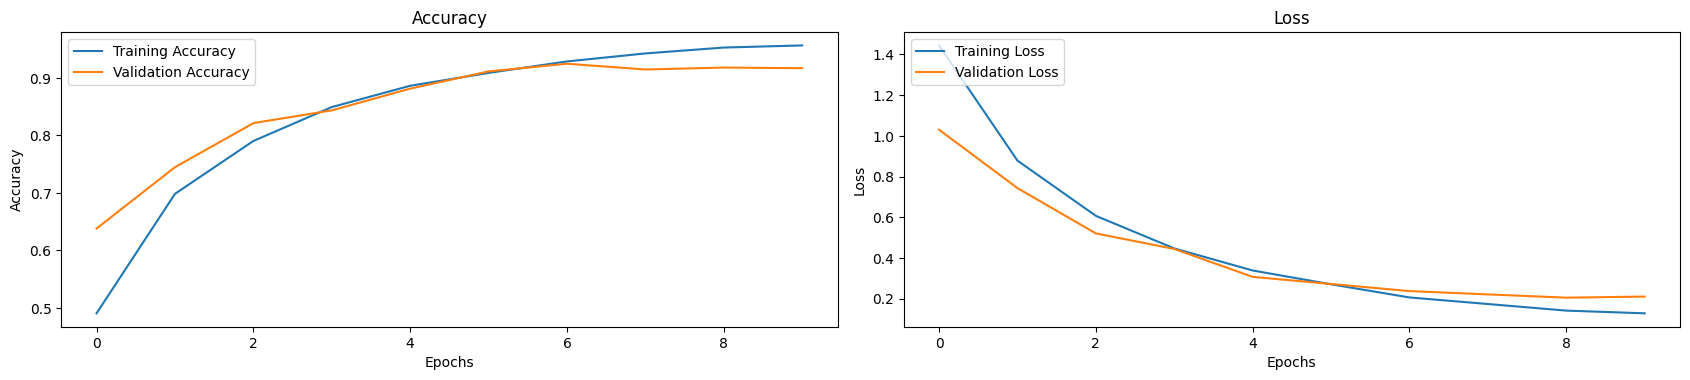

In [19]:
# Modelin egitim gecmisi
history = mo_fit.history

# Anahtar isimlerini kontrol ederek grafik cizimi
accuracy = history.get('accuracy', [])
validation_accuracy = history.get('val_accuracy', [])
loss = history.get('loss', [])
validation_loss = history.get('val_loss', [])

# Grafik cizimi
plt.figure(figsize=(17, 7))

# Dogruluk grafigi
plt.subplot(2, 2, 1)
if accuracy and validation_accuracy:
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
else:
    print("Accuracy veya Validation Accuracy verileri eksik!")

# Kayip grafigi
plt.subplot(2, 2, 2)
if loss and validation_loss:
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
else:
    print("Loss veya Validation Loss verileri eksik!")

plt.tight_layout()
plt.show()

 Bu kod parçasının amacı, modelin eğitim sürecindeki performansını görselleştirmektir. Eğitim ve doğrulama doğruluğu ile kaybını (loss) grafikler üzerinden göstererek, modelin nasıl öğrendiğini ve genel eğilimleri anlamayı sağlar.1.NumPy, Pandas, TensorFlow ve Keras gibi kütüphaneler kullanıldı ve görüntü verileri ile çalışmak için altyapı hazırlandı.